In [1]:
!pip install torch
!pip install torchvision
!pip install segmentation_models_pytorch
!pip install timm
!pip install matplotlib
!pip install scikit-learn


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 4.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=bdba9a3c7ddba9989e0d3aa445c519eca358b0de517d971adbd6f5fd7168b8b6
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=7c5dd804f2ed6a99f209f41b9c16aa33a246927009ceea7c9f0b8889f3371af8
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
!pip install timm


In [3]:
import os
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.metrics import classification_report, confusion_matrix

In [4]:
##############################################
# STEP A: Offline Data Augmentation & Expansion
##############################################
# Set paths for the original (small) PH2 dataset and the target augmented folder.
# The original folder should have 3 subfolders: common_nevus, atypical_nevus, melanoma.
ORIG_DATA_DIR = "/kaggle/input/rashidul-update/Categories"      # e.g., contains common_nevus/, atypical_nevus/, melanoma/
AUG_DATA_DIR  = "/kaggle/working/PH2_AUGMENTED"       # This folder will be created with expanded data
NUM_AUG_COPIES = 10  # Number of augmented copies per original image (~200*10 = 2000 images)

# Define an offline augmentation pipeline (aggressive but realistic)
offline_augment = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # random crop
])

def create_augmented_dataset(orig_dir, aug_dir, copies=10):
    """
    For each image in orig_dir/[class], apply random transformations
    and save 'copies' augmented versions to aug_dir/[class].
    Images are saved as .jpg to ensure compatibility.
    """
    if not os.path.exists(aug_dir):
        os.makedirs(aug_dir)
    
    # List only subdirectories (classes)
    classes = [c for c in os.listdir(orig_dir) if os.path.isdir(os.path.join(orig_dir, c))]
    print("Classes found in original dataset:", classes)
    
    for cls in classes:
        orig_cls_path = os.path.join(orig_dir, cls)
        aug_cls_path  = os.path.join(aug_dir, cls)
        if not os.path.exists(aug_cls_path):
            os.makedirs(aug_cls_path)
        # List image files with common extensions (you can add more if needed)
        img_files = [f for f in os.listdir(orig_cls_path) if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
        for img_name in img_files:
            orig_img_path = os.path.join(orig_cls_path, img_name)
            try:
                image = Image.open(orig_img_path).convert("RGB")
            except Exception as e:
                print(f"Error loading {orig_img_path}: {e}")
                continue
            # Save the original image as well (optional)
            base, _ = os.path.splitext(img_name)
            image.save(os.path.join(aug_cls_path, f"{base}_orig.jpg"))
            # Generate 'copies' augmented images
            for i in range(copies):
                aug_image = offline_augment(image)
                new_name = f"{base}_aug{i}.jpg"
                aug_image.save(os.path.join(aug_cls_path, new_name))
    print("Offline augmentation complete.")

# Run offline augmentation (this expands your dataset)
create_augmented_dataset(ORIG_DATA_DIR, AUG_DATA_DIR, copies=NUM_AUG_COPIES)

# (Optional) Verify structure:
print("Augmented dataset structure:")
for root, dirs, files in os.walk(AUG_DATA_DIR):
    print("ROOT:", root)
    print("FILES:", files[:3])
    print("-----")

Classes found in original dataset: ['atypical_nevus', 'melanoma', 'common_nevus']
Offline augmentation complete.
Augmented dataset structure:
ROOT: /kaggle/working/PH2_AUGMENTED
FILES: []
-----
ROOT: /kaggle/working/PH2_AUGMENTED/common_nevus
FILES: ['IMD101_aug8.jpg', 'IMD364_aug3.jpg', 'IMD204_orig.jpg']
-----
ROOT: /kaggle/working/PH2_AUGMENTED/atypical_nevus
FILES: ['IMD030_aug1.jpg', 'IMD008_aug6.jpg', 'IMD356_aug9.jpg']
-----
ROOT: /kaggle/working/PH2_AUGMENTED/melanoma
FILES: ['IMD080_aug7.jpg', 'IMD242_orig.jpg', 'IMD429_aug2.jpg']
-----


In [5]:
##############################################
# STEP B: Data Preparation: 80/20 Split (Using Expanded Data)
##############################################
# We'll use a robust online augmentation (if desired) along with normalization.
# Here, we use only resizing and normalization since heavy augmentation was done offline.
img_size = 224  # Define the image size for resizing
batch_size = 32  # Define the batch size for DataLoad
online_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally
    transforms.RandomRotation(10),  # Rotate images by ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color changes
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Load the expanded dataset using ImageFolder.
dataset = datasets.ImageFolder(root=AUG_DATA_DIR, transform=online_transform)
print("Classes (from augmented dataset):", dataset.class_to_idx)
dataset_size = len(dataset)
train_size   = int(0.8 * dataset_size)
test_size    = dataset_size - train_size

train_dataset, test_dataset = random_split(
    dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Total images (augmented):", dataset_size)
print("Training samples:", len(train_dataset))
print("Testing samples :", len(test_dataset))

Classes (from augmented dataset): {'atypical_nevus': 0, 'common_nevus': 1, 'melanoma': 2}
Total images (augmented): 2200
Training samples: 1760
Testing samples : 440


In [6]:
import os
import pandas as pd
from torch.utils.data import random_split
import torch
from torchvision import datasets, transforms

# Define dataset directories
ORIG_DATA_DIR = "/kaggle/input/rashidul-update/Categories"
AUG_DATA_DIR  = "/kaggle/working/PH2_AUGMENTED"

# Function to count images in each class
def count_images_in_classes(data_dir):
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):  # Ensure it's a directory
            num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))])
            class_counts[class_name] = num_images
    return class_counts

# Get counts for Original and Augmented datasets
orig_counts = count_images_in_classes(ORIG_DATA_DIR)
aug_counts = count_images_in_classes(AUG_DATA_DIR)

# Load the augmented dataset with transformations
img_size = 224  
online_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=AUG_DATA_DIR, transform=online_transform)

# Split dataset into training (80%) and testing (20%)
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# Function to count class samples in train/test datasets
def count_class_samples(dataset):
    class_counts = {class_name: 0 for class_name in dataset.dataset.class_to_idx.keys()}
    for idx in dataset.indices:
        class_label = dataset.dataset.targets[idx]
        class_name = list(dataset.dataset.class_to_idx.keys())[class_label]
        class_counts[class_name] += 1
    return class_counts

train_counts = count_class_samples(train_dataset)
test_counts = count_class_samples(test_dataset)

# Convert data to Pandas DataFrame for tabular format
df = pd.DataFrame({
    "Class": list(orig_counts.keys()),
    "Original Dataset": [orig_counts.get(cls, 0) for cls in orig_counts.keys()],
    "Augmented Dataset": [aug_counts.get(cls, 0) for cls in aug_counts.keys()],
    "Training Set (80%)": [train_counts.get(cls, 0) for cls in train_counts.keys()],
    "Testing Set (20%)": [test_counts.get(cls, 0) for cls in test_counts.keys()]
})

# Print table format
print(df)

# Save the table as CSV for easy transfer
#df.to_csv("/kaggle/working/data_distribution.csv", index=False)


            Class  Original Dataset  Augmented Dataset  Training Set (80%)  \
0  atypical_nevus                80                880                 699   
1        melanoma                40                880                 711   
2    common_nevus                80                440                 350   

   Testing Set (20%)  
0                181  
1                169  
2                 90  


## Step 1: Implementing SE Blocks (Squeeze-and-Excitation)
We will implement the Squeeze-and-Excitation block and insert it within the DenseNet201 architecture. The SE block can be added as a channel-wise attention mechanism

In [7]:
import tensorflow as tf

# Load the Keras DenseNet201 model without the top layers (excluding classifier)
keras_model = tf.keras.applications.DenseNet201(
    include_top=False,  # Exclude the top (classification) layers
    weights=None  # We'll load weights manually
)

# Load the weights from the manually downloaded .h5 file
keras_model.load_weights('/kaggle/input/densenet-weights/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5')


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import tensorflow as tf
import numpy as np

# Define the SE Block (Squeeze-and-Excitation)
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=8):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channel, channel // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channel // reduction, channel, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Global average pooling
        b, c, _, _ = x.size()
        y = torch.mean(x, dim=(2, 3), keepdim=True)  # Global spatial average
        y = y.view(b, c)  # Flatten the spatial dimensions
        y = self.fc1(y)  # Reduce the dimension
        y = self.relu(y)
        y = self.fc2(y)  # Rebuild the original channel dimension
        y = self.sigmoid(y).view(b, c, 1, 1)  # Apply sigmoid activation and reshape
        return x * y.expand_as(x)  # Apply the attention mechanism

# Load pre-trained DenseNet201 and modify it
class DenseNet201WithSE(nn.Module):
    def __init__(self):
        super(DenseNet201WithSE, self).__init__()
        self.densenet = models.densenet201(pretrained=False)  # Use pretrained=False as we'll load weights manually
        self.se_block = SEBlock(channel=1920, reduction=8)  # The output channels of DenseNet201's last feature layer

        # Updated classifier with dropout and batch normalization
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Dropout(0.7),  # Increased dropout rate for better regularization
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 3)  # 3 classes for classification
        )

        # Load Keras weights
        self.load_keras_weights()

    def load_keras_weights(self):
        # Load the Keras model with the pre-trained weights
        keras_model = tf.keras.applications.DenseNet201(
            include_top=False,  # Exclude top layers (no classifier)
            weights=None
        )
        keras_model.load_weights('/kaggle/input/densenet-weights/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5')

        # Transfer weights from Keras to PyTorch model (DenseNet layers)
        keras_weights = keras_model.get_weights()

        # Here you will need to match the weights between Keras layers and PyTorch layers
        # For example, the weights of the convolutional layers
        keras_conv_weights = keras_weights[:len(self.densenet.features)]  # Adjust this based on the model

        # Transfer weights to PyTorch model
        for i, layer in enumerate(self.densenet.features):
            if isinstance(layer, nn.Conv2d):  # If the layer is a convolutional layer
                layer.weight = nn.Parameter(torch.from_numpy(keras_conv_weights[i]).float())

    def forward(self, x):
        features = self.densenet.features(x)
        features = self.se_block(features)  # Apply SE block to the feature maps

        # Adaptive Average Pooling ensures proper flattening
        out = F.adaptive_avg_pool2d(features, (1, 1))
        out = torch.flatten(out, 1)  # Ensures correct shape
        out = self.densenet.classifier(out)

        return out

# Instantiate the model and move it to the device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet201WithSE()
model.to(device)

# Now you can continue with training


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DenseNet201WithSE(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, m

## Step 2: Focal Loss Implementation
We'll implement Focal Loss and replace the standard CrossEntropyLoss with it. Focal Loss helps in cases of class imbalance by focusing more on difficult-to-classify.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        # Apply log_softmax for numerical stability
        log_prob = F.log_softmax(inputs, dim=1)
        
        # Calculate the cross-entropy loss
        ce_loss = -log_prob.gather(dim=1, index=targets.unsqueeze(1))
        
        # Get probabilities for each class
        pt = torch.exp(-ce_loss)
        
        # Apply class-specific weighting if alpha is provided
        if self.alpha is not None:
            alpha_t = self.alpha.gather(dim=0, index=targets)
            ce_loss = alpha_t * (1 - pt) ** self.gamma * ce_loss
        else:
            ce_loss = (1 - pt) ** self.gamma * ce_loss
        
        return ce_loss.mean()

# Define class weights based on class distribution (inversely proportional to class counts)
class_counts = [350, 711, 699]  # Replace with actual class counts: [Class 0, Class 1, Class 2]
class_weights = [sum(class_counts) / c for c in class_counts]  # Inverse frequency

# Convert class weights into a tensor and assign to alpha for Focal Loss
weights = torch.FloatTensor(class_weights).to(device)

# Use the modified Focal Loss with class-specific weighting
criterion = FocalLoss(gamma=2, alpha=weights)


## Step 3: Mixup Data Augmentation
Mixup is an augmentation technique where two images and their labels are combined during training to create new, synthetic images.

In [10]:
import torch
import numpy as np

def mixup_data(x, y, alpha=1.0, device=None):
    """ Mixup data augmentation with targeted adjustments for class imbalance. """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1  # If alpha is 0, use lam = 1 (no mixup)

    # Convert `lam` to a PyTorch tensor and move it to the correct device
    lam = torch.tensor(lam, dtype=torch.float32, device=device)

    # Shuffle indices and move to the correct device
    index = torch.randperm(x.size(0), device=device)  # Shuffle indices

    # Perform mixup augmentation
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    # Optionally, increase alpha for Class 0 (minority class)
    if torch.sum(y == 0).item() > 0:  # If there are any samples from Class 0
        lam = np.random.beta(alpha * 2, alpha * 2)  # Apply stronger mixup to Class 0

    return mixed_x, y_a, y_b, lam


## Step 4: Fine-Tuning Pretrained Weights with Learning Rate Scheduling
We will load pretrained weights for DenseNet201 and fine-tune the model using OneCycleLR for learning rate scheduling.

In [11]:
import torch.optim as optim

# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained model
model = DenseNet201WithSE()
model.to(device)

# Fine-tuning optimizer (Adam with weight decay)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Added weight decay for regularization

# Learning rate scheduler (OneCycleLR)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                           max_lr=0.005,  # Increase max_lr for faster convergence
                                           steps_per_epoch=len(train_loader), 
                                           epochs=50,  # Increased the number of epochs for better training
                                           pct_start=0.3,  # Warm-up portion for better training stability
                                           anneal_strategy='cos',  # Cosine annealing for smoother reduction
                                           cycle_momentum=False)  # Disable momentum adjustment (optional)


## Step 5: Dropout Layer for Regularization
Adding Dropout layers inside the model helps regularize the network and prevents overfitting.


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py
from collections import OrderedDict
import torchvision.models as models

# Define the SE Block (Squeeze-and-Excitation)
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=8):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channel, channel // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channel // reduction, channel, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Global average pooling
        b, c, _, _ = x.size()
        y = torch.mean(x, dim=(2, 3), keepdim=True)  # Global spatial average
        y = y.view(b, c)  # Flatten the spatial dimensions
        y = self.fc1(y)  # Reduce the dimension
        y = self.relu(y)
        y = self.fc2(y)  # Rebuild the original channel dimension
        y = self.sigmoid(y).view(b, c, 1, 1)  # Apply sigmoid activation and reshape
        return x * y.expand_as(x)  # Apply the attention mechanism

# Load pre-trained DenseNet201 and modify it
class DenseNet201WithSE(nn.Module):
    def __init__(self, weights_path=None):
        super(DenseNet201WithSE, self).__init__()
        self.densenet = models.densenet201(pretrained=False)  # Do not load pre-trained weights from PyTorch
        self.se_block = SEBlock(channel=1920, reduction=8)

        # Updated classifier with stronger dropout and batch normalization
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Dropout(0.7),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 3)  # Output layer for 3 classes
        )

        if weights_path:
            self.load_weights(weights_path)

    def load_weights(self, weights_path):
        # Open the HDF5 file containing the Keras model weights
        with h5py.File(weights_path, 'r') as f:
            # Create an OrderedDict to hold the weights
            state_dict = OrderedDict()

            # Example: Load weights for the convolutional layers
            for name, param in self.densenet.features.named_parameters():
                keras_name = f'conv{param.shape[0]}_weights'  # This is just an example, adjust as needed
                if keras_name in f:
                    state_dict[name] = torch.tensor(f[keras_name][()])

            # Load the state_dict into the model (allow missing layers)
            self.densenet.load_state_dict(state_dict, strict=False)

    def forward(self, x):
        features = self.densenet.features(x)
        features = self.se_block(features)  # Apply SE block to the feature maps

        # Adaptive Average Pooling ensures proper flattening
        out = F.adaptive_avg_pool2d(features, (1, 1))
        out = torch.flatten(out, 1)  # Ensures correct shape
        out = self.densenet.classifier(out)

        return out

# Instantiate the model and move it to the device (GPU/CPU)
dropout_rate = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights_path = '/kaggle/input/densenet-weights/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5'  # Your manually downloaded weights
model = DenseNet201WithSE(weights_path)
model.to(device)


DenseNet201WithSE(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, m

## Step 6: Training the Model
Now that your model is set up, you can train it using the data you prepared earlier. Here's how we can set up the training loop, including the use of the mixup data augmentation and learning rate scheduler:

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F

# Define device (ensure it's defined before using)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the SE Block (Squeeze-and-Excitation)
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channel, channel // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channel // reduction, channel, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Global average pooling
        b, c, _, _ = x.size()
        y = torch.mean(x, dim=(2, 3), keepdim=True)  # Global spatial average
        y = y.view(b, c)  # Flatten the spatial dimensions
        y = self.fc1(y)  # Reduce the dimension
        y = self.relu(y)
        y = self.fc2(y)  # Rebuild the original channel dimension
        y = self.sigmoid(y).view(b, c, 1, 1)  # Apply sigmoid activation and reshape
        return x * y.expand_as(x)  # Apply the attention mechanism

# Load pre-trained DenseNet201 and modify it
class DenseNet201WithSE(nn.Module):
    def __init__(self):
        super(DenseNet201WithSE, self).__init__()
        self.densenet = models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1)  # Updated weight loading
        self.se_block = SEBlock(channel=1920)  # The output channels of DenseNet201's last feature layer
        
        # Modify the classifier with Dropout and BatchNorm
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Increased dropout rate for stronger regularization
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # Add batch normalization
            nn.Linear(512, 3)  # Final classification layer for 3 classes
        )

    def forward(self, x):
        # Forward pass through DenseNet layers
        features = self.densenet.features(x)

        # Apply SE block for channel-wise attention
        features = self.se_block(features)

        # Pass the features through the classifier
        out = F.adaptive_avg_pool2d(features, (1, 1))  # Adaptive pooling for consistent size
        out = torch.flatten(out, 1)  # Flatten for classifier
        out = self.densenet.classifier(out)

        return out

# Instantiate the model and move it to the device (GPU or CPU)
model = DenseNet201WithSE()
model.to(device)

# Optimizer setup with weight decay added for regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Adjusted weight decay to prevent overfitting

# Learning Rate Scheduler setup (OneCycleLR for aggressive learning rate scheduling)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                           max_lr=0.005,  # Experiment with max_lr for faster convergence
                                           steps_per_epoch=len(train_loader), 
                                           epochs=50,  # Increased the number of epochs for better training
                                           pct_start=0.3,  # Warm-up portion for better training stability
                                           anneal_strategy='cos',  # Cosine annealing for smoother reduction
                                           cycle_momentum=False)  # Disable momentum adjustment (optional)


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 169MB/s]


In [14]:
import torch
import torch.optim as optim
import torch.nn.functional as F

# Training loop
num_epochs = 50  # Number of epochs
best_loss = float('inf')
patience = 7  # Stop training if no improvement for 7 epochs
counter = 0  # Counter for early stopping

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Apply Mixup Data Augmentation
        mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=1.0, device=device)

        mixed_inputs, targets_a, targets_b = mixed_inputs.to(device), targets_a.to(device), targets_b.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(mixed_inputs)

        # Compute the loss (mixup loss)
        loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += targets_a.size(0)
        correct += (predicted == targets_a).sum().item()

    # Compute average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    # Step the learning rate scheduler (ReduceLROnPlateau needs loss as an argument)
    scheduler.step(epoch_loss)

    # Print statistics after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # Early Stopping Check
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        counter = 0  # Reset patience counter
        torch.save(model.state_dict(), 'best_densenet201.pth')  # Save best model
        print("✅ Best model saved!")
    else:
        counter += 1  # Increase patience counter
    
    if counter >= patience:
        print("⏹️ Early stopping triggered. Stopping training.")
        break  # Stop training if no improvement

    # Optionally clear cache to avoid memory overload on GPU (especially for large datasets)
    torch.cuda.empty_cache()

# Final model save
torch.save(model.state_dict(), 'final_densenet201.pth')
print("🎯 Training complete! Best model and final model saved.")


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [1/50], Loss: 1.9830, Accuracy: 42.61%
✅ Best model saved!
Epoch [2/50], Loss: 1.7655, Accuracy: 48.98%
✅ Best model saved!
Epoch [3/50], Loss: 1.6102, Accuracy: 54.49%
✅ Best model saved!
Epoch [4/50], Loss: 1.5799, Accuracy: 56.19%
✅ Best model saved!
Epoch [5/50], Loss: 1.4583, Accuracy: 53.18%
✅ Best model saved!
Epoch [6/50], Loss: 1.4362, Accuracy: 54.83%
✅ Best model saved!
Epoch [7/50], Loss: 1.3929, Accuracy: 55.97%
✅ Best model saved!
Epoch [8/50], Loss: 1.4042, Accuracy: 53.86%
Epoch [9/50], Loss: 1.4078, Accuracy: 55.34%
Epoch [10/50], Loss: 1.3057, Accuracy: 58.47%
✅ Best model saved!
Epoch [11/50], Loss: 1.2891, Accuracy: 63.47%
✅ Best model saved!
Epoch [12/50], Loss: 1.2337, Accuracy: 60.62%
✅ Best model saved!
Epoch [13/50], Loss: 1.2308, Accuracy: 66.76%
✅ Best model saved!
Epoch [14/50], Loss: 1.1835, Accuracy: 56.14%
✅ Best model saved!
Epoch [15/50], Loss: 1.2003, Accuracy: 60.23%
Epoch [16/50], Loss: 1.2186, Accuracy: 61.19%
Epoch [17/50], Loss: 1.1778, Accu

<ipython-input-16-d1eefe9a72a7>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_densenet201.pth"))


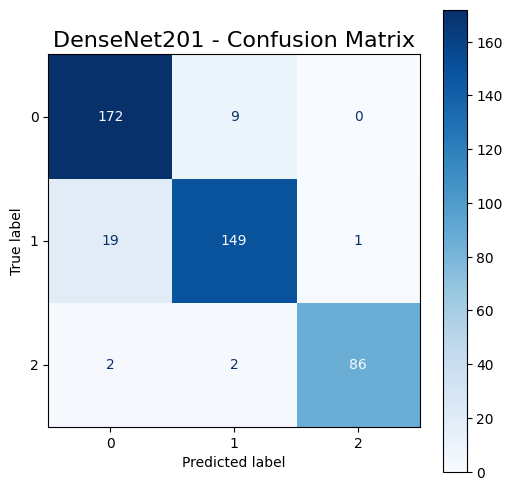

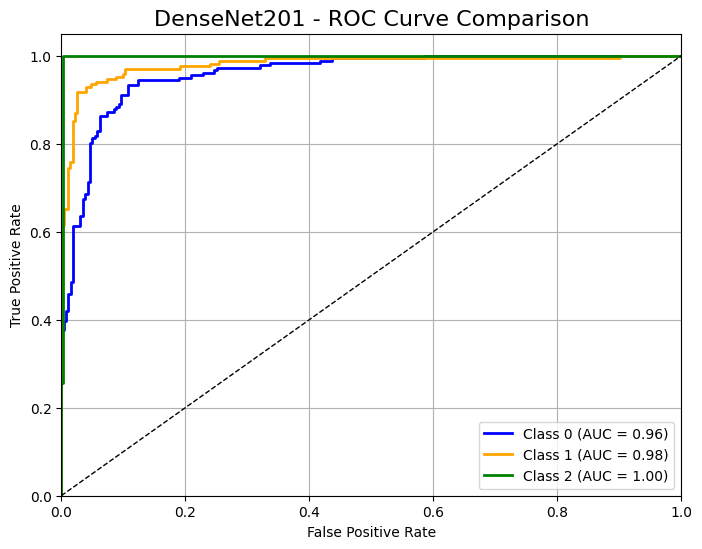

In [16]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Load the best model
model.load_state_dict(torch.load("best_densenet201.pth"))
model.eval()

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        outputs = model(data)

        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = target.cpu().numpy()

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels)

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# --------- 📊 Confusion Matrix ---------
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

fig_cm, ax_cm = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax_cm, cmap='Blues', values_format='d')
ax_cm.set_title("DenseNet201 - Confusion Matrix", fontsize=16)
fig_cm.set_facecolor("white")
plt.savefig("densenet201_confusion_matrix.png", bbox_inches='tight')
plt.show()

# --------- 📈 ROC Curve ---------
# Binarize the labels for ROC curve
n_classes = 3
y_test_bin = label_binarize(all_labels, classes=[0, 1, 2])
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("DenseNet201 - ROC Curve Comparison", fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.gcf().set_facecolor("white")
plt.savefig("densenet201_roc_curve.png", bbox_inches='tight')
plt.show()


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.86      0.92      0.89       181
     Class 1       0.92      0.85      0.89       169
     Class 2       0.98      0.98      0.98        90

    accuracy                           0.91       440
   macro avg       0.92      0.92      0.92       440
weighted avg       0.91      0.91      0.91       440



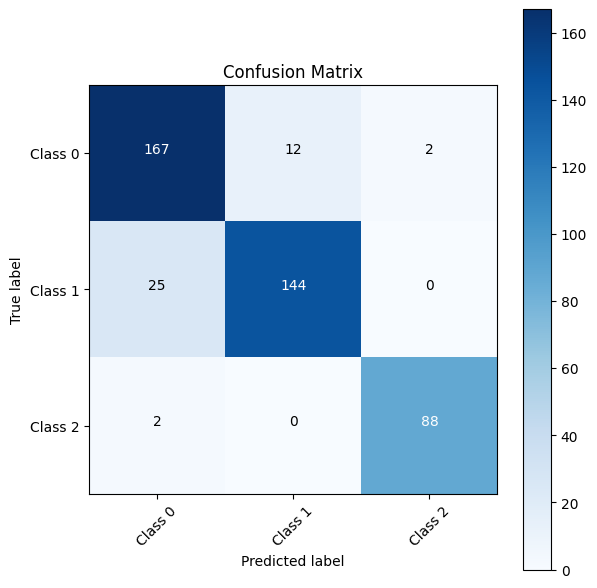

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import torch.nn.functional as F

# Set the model to evaluation mode
model.eval()

# Initialize variables to store true labels and predictions
all_labels = []
all_preds = []

# Run the evaluation loop
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Get model predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Store the results
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Generate the classification report
report = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1', 'Class 2'])
print("Classification Report:")
print(report)

# Visualize the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=['Class 0', 'Class 1', 'Class 2'], normalize=False, title="Confusion Matrix")
plt.show()